# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
100% 235k/235k [00:00<00:00, 428kB/s]
100% 235k/235k [00:00<00:00, 428kB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [72]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.3 MB/s eta 0:00:00


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt
from keras.optimizers import Adam

In [3]:
df = pd.read_csv('/content/Traffic Data.csv',parse_dates=['date_time'])

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [4]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       19980 non-null  float64       
 1   temp                 20000 non-null  float64       
 2   rain_1h              20000 non-null  float64       
 3   snow_1h              20000 non-null  float64       
 4   clouds_all           20000 non-null  int64         
 5   weather_main         20000 non-null  object        
 6   weather_description  20000 non-null  object        
 7   date_time            20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [6]:
df.set_index('date_time',inplace=True)
df.sort_index(inplace=True)

In [7]:
df.isna().sum()


,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [8]:
df.shape

(20000, 7)

In [9]:
df.index.year.value_counts()

,count
date_time,
2017,10605
2018,7949
2016,1446


<Axes: xlabel='date_time'>

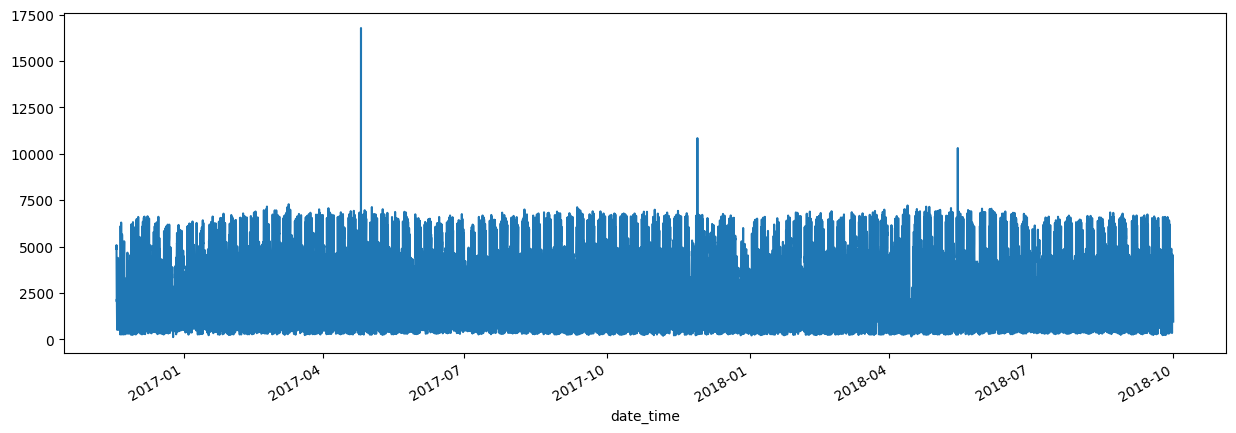

In [10]:
df['traffic_volume'].plot(figsize=(15,5))

<Axes: xlabel='date_time'>

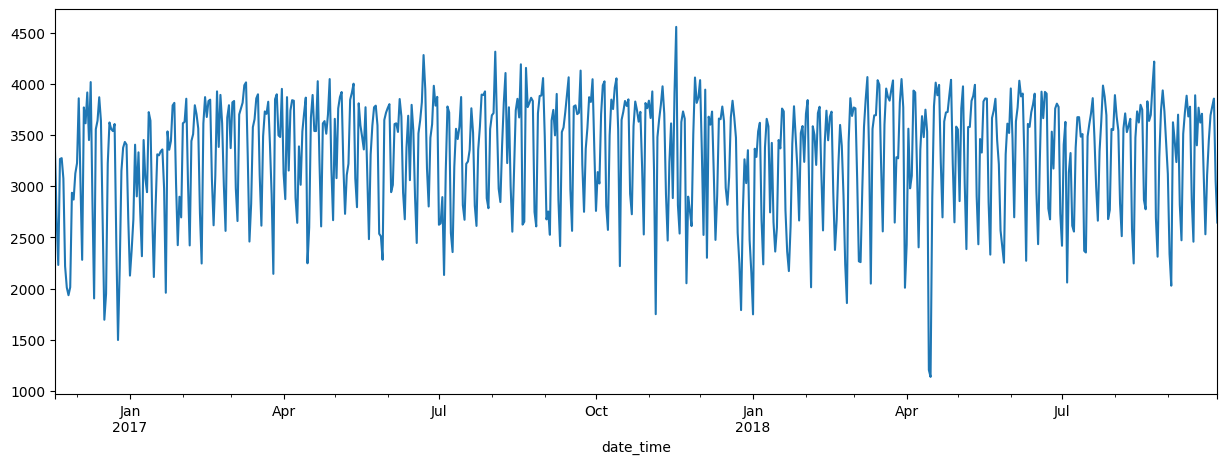

In [11]:
df['traffic_volume'].resample('D').mean().plot(figsize=(15,5))

<Axes: xlabel='date_time'>

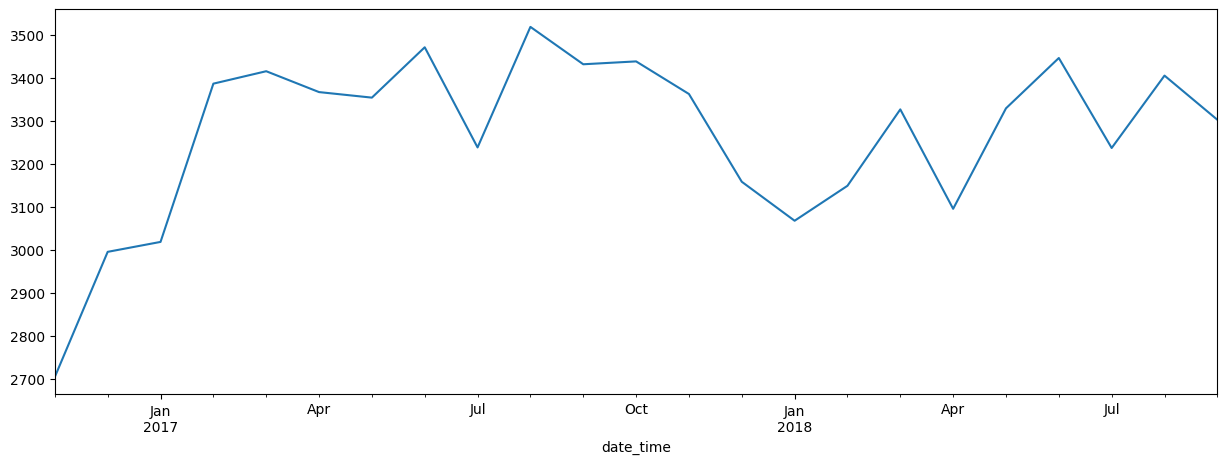

In [12]:
df['traffic_volume'].resample('M').mean().plot(figsize=(15,5))

<Axes: xlabel='date_time'>

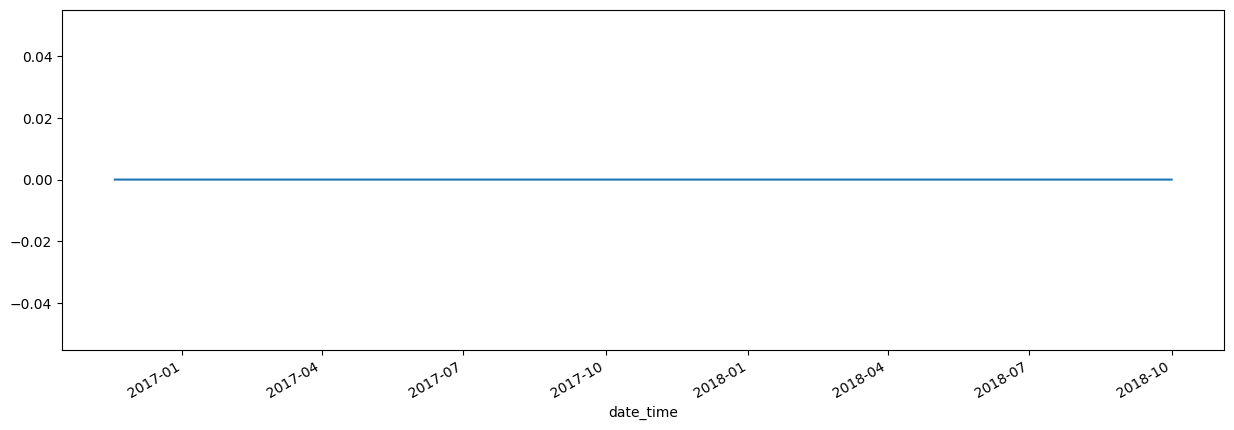

In [13]:
df['snow_1h'].plot(figsize=(15,5))

<Axes: xlabel='date_time'>

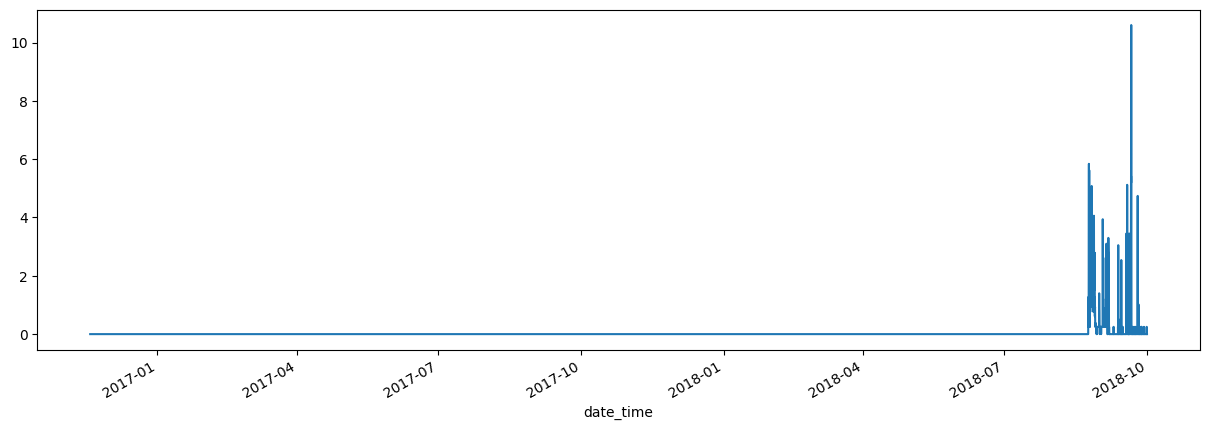

In [14]:
df['rain_1h'].plot(figsize=(15,5))

<Axes: xlabel='date_time'>

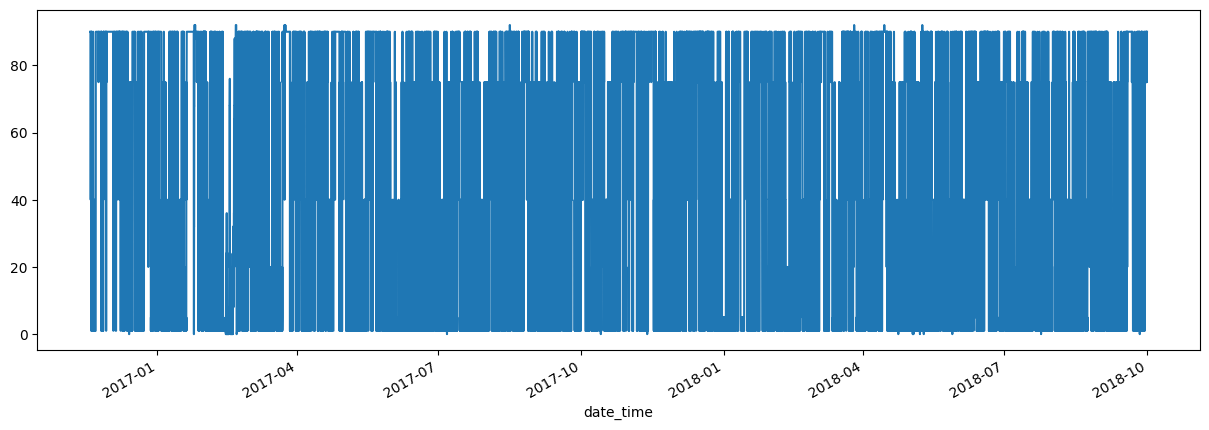

In [15]:
df['clouds_all'].plot(figsize=(15,5))

In [16]:
df['weather_description'].value_counts()

,count
weather_description,
sky is clear,5514
mist,2758
overcast clouds,1738
broken clouds,1574
scattered clouds,1458
light snow,1247
light rain,1201
moderate rain,747
haze,672


In [17]:
df['weather_main'].value_counts()

,count
weather_main,
Clear,5614
Clouds,5234
Mist,2758
Rain,2244
Snow,1462
Drizzle,993
Haze,672
Thunderstorm,542
Fog,478


<Axes: xlabel='date_time'>

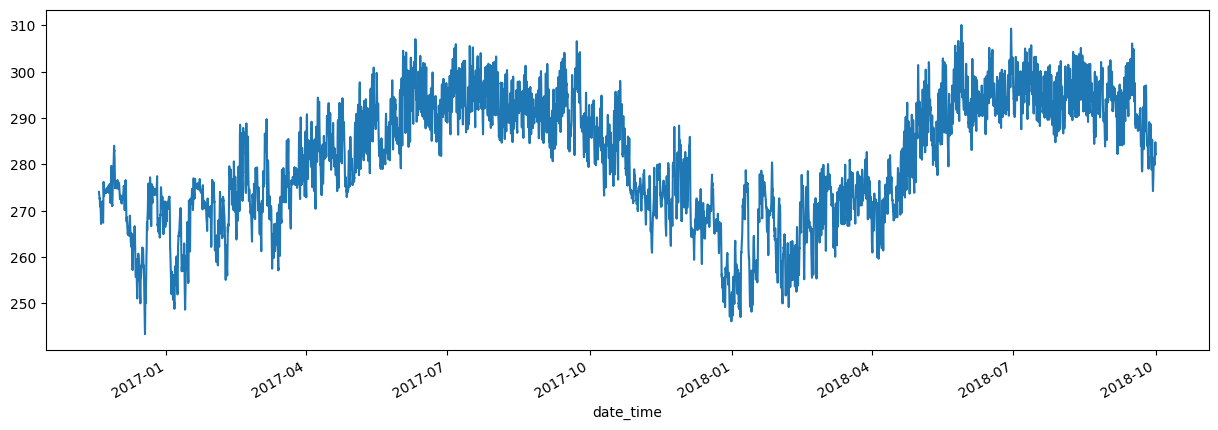

In [18]:
df['temp'].plot(figsize=(15,5))

In [19]:
df['traffic_volume'].fillna(method='bfill',inplace=True)

<ipython-input-19-a55011c93323>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['traffic_volume'].fillna(method='bfill',inplace=True)


In [20]:
df.isna().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [21]:
decompose = seasonal_decompose(df['traffic_volume'],period=24)

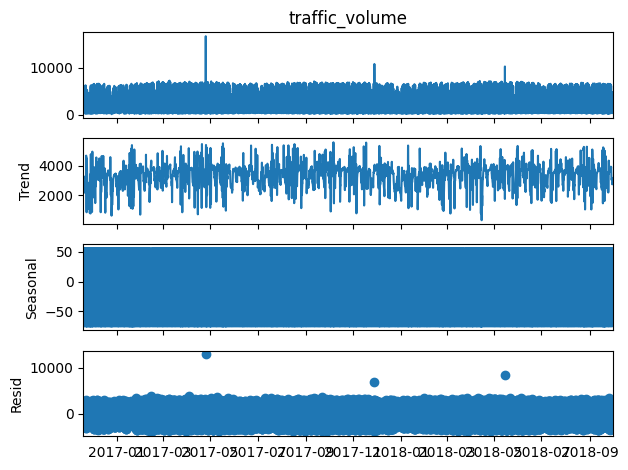

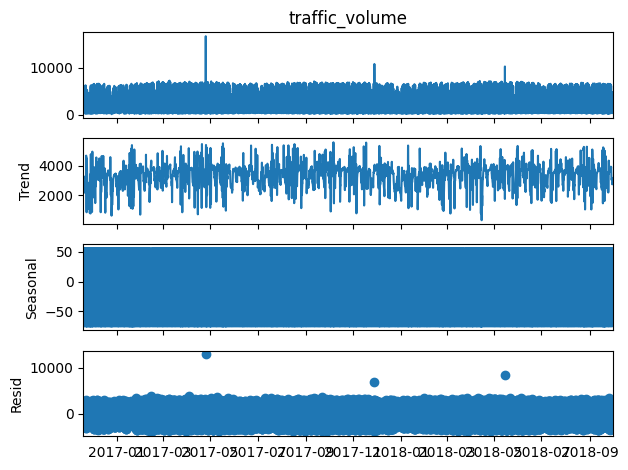

In [22]:
decompose.plot()

<Axes: >

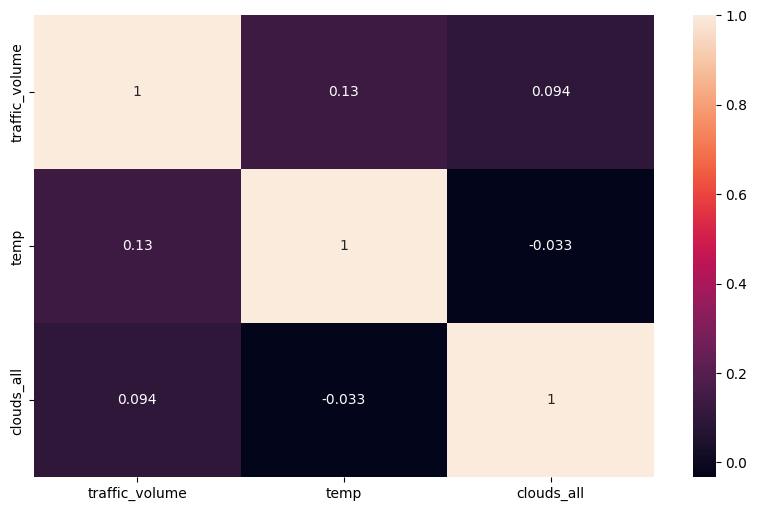

In [23]:
plt.figure(figsize=(10,6))
sns.heatmap(df.drop(columns=['weather_description','weather_main','snow_1h','rain_1h']).corr(),annot=True)

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [24]:
#Missing Values are handeled above
#date is sorted above

In [25]:
df.drop(columns=['rain_1h','snow_1h','clouds_all','weather_description','weather_main'],inplace=True)

In [26]:
df.columns

Index(['traffic_volume', 'temp'], dtype='object')

In [27]:
from scipy.stats import zscore

imputed_series = df['traffic_volume'].copy()

window_size = 90
for i in range(window_size-window_size, len(df) - window_size, window_size):
    window = df['traffic_volume'].iloc[i - window_size:i]
    z_scores = zscore(window)

    outliers = np.where(np.abs(z_scores) > 3)[0]

    for outlier in outliers:
        imputed_series.iloc[i - window_size + outlier] = np.nan

imputed_series.ffill(inplace=True)


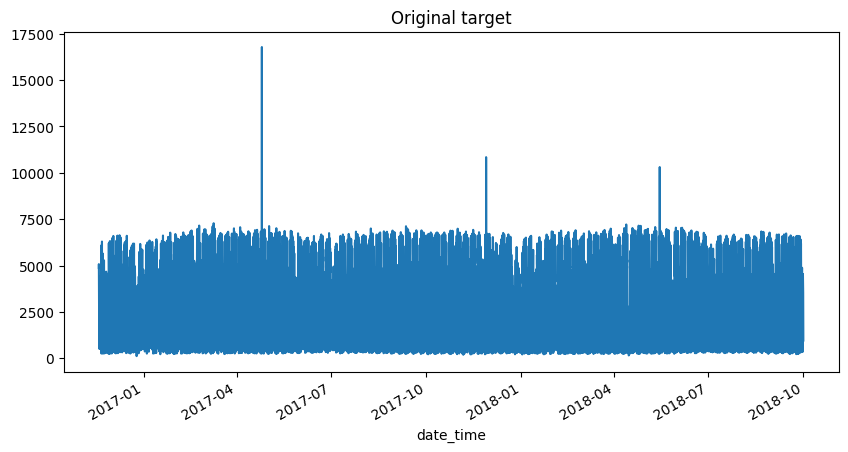

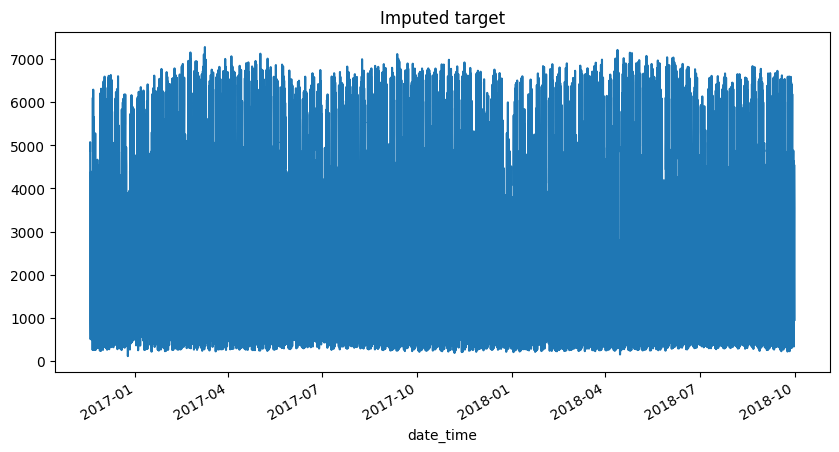

In [28]:
plt.figure(figsize=(10, 5))
df['traffic_volume'].plot()
plt.title('Original target')
plt.show()

plt.figure(figsize=(10, 5))
imputed_series.plot()
plt.title('Imputed target')
plt.show()

In [29]:
df['traffic_volume']= imputed_series

In [30]:
df.isna().sum()

,0
traffic_volume,0
temp,0


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


<Axes: xlabel='date_time'>

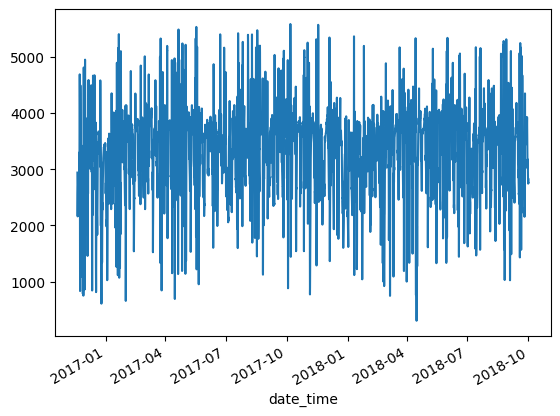

In [31]:
df['traffic_moving_avg_24h'] = df['traffic_volume'].rolling(window=24).mean()
df['traffic_moving_avg_24h'].plot()

In [32]:
df.head()

,traffic_volume,temp,traffic_moving_avg_24h
date_time,,,
2016-11-18 15:00:00,4872.0,274.08,NaN
2016-11-18 15:00:00,4872.0,274.08,NaN
2016-11-18 15:00:00,4872.0,274.08,NaN
2016-11-18 16:00:00,5074.0,273.84,NaN
2016-11-18 16:00:00,5074.0,273.84,NaN


In [33]:
df.fillna(method='bfill',inplace=True)

<ipython-input-33-71c2b11f6341>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill',inplace=True)


In [34]:
df.head(24)

,traffic_volume,temp,traffic_moving_avg_24h
date_time,,,
2016-11-18 15:00:00,4872.0,274.08,2940.416667
2016-11-18 15:00:00,4872.0,274.08,2940.416667
2016-11-18 15:00:00,4872.0,274.08,2940.416667
2016-11-18 16:00:00,5074.0,273.84,2940.416667
2016-11-18 16:00:00,5074.0,273.84,2940.416667
2016-11-18 16:00:00,5074.0,273.84,2940.416667
2016-11-18 17:00:00,4328.0,273.62,2940.416667
2016-11-18 17:00:00,4328.0,273.62,2940.416667
2016-11-18 17:00:00,4328.0,273.62,2940.416667


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [35]:
df.head()

,traffic_volume,temp,traffic_moving_avg_24h
date_time,,,
2016-11-18 15:00:00,4872.0,274.08,2940.416667
2016-11-18 15:00:00,4872.0,274.08,2940.416667
2016-11-18 15:00:00,4872.0,274.08,2940.416667
2016-11-18 16:00:00,5074.0,273.84,2940.416667
2016-11-18 16:00:00,5074.0,273.84,2940.416667


In [36]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

train_data, test_data = train_test_split(df, test_size=0.3, shuffle=False)
val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)

train_data_scaled = feature_scaler.fit_transform(train_data[['temp','traffic_moving_avg_24h']])
train_data[['temp','traffic_moving_avg_24h']] = train_data_scaled
train_data['traffic_volume'] = target_scaler.fit_transform(train_data[['traffic_volume']])

val_data_scaled = feature_scaler.transform(val_data[['temp','traffic_moving_avg_24h']])
val_data[['temp','traffic_moving_avg_24h']] = val_data_scaled
val_data['traffic_volume'] = target_scaler.transform(val_data[['traffic_volume']])

test_data_scaled = feature_scaler.transform(test_data[['temp','traffic_moving_avg_24h']])
test_data[['temp','traffic_moving_avg_24h']] = test_data_scaled
test_data['traffic_volume'] = target_scaler.transform(test_data[['traffic_volume']])

In [37]:
train_data.head()

,traffic_volume,temp,traffic_moving_avg_24h
date_time,,,
2016-11-18 15:00:00,0.664016,0.482320,0.468669
2016-11-18 15:00:00,0.664016,0.482320,0.468669
2016-11-18 15:00:00,0.664016,0.482320,0.468669
2016-11-18 16:00:00,0.692200,0.478548,0.468669
2016-11-18 16:00:00,0.692200,0.478548,0.468669


In [38]:
train_data = train_data.values
val_data = val_data.values
test_data = test_data.values

In [39]:
win_size = 24

train_ds = timeseries_dataset_from_array(
    train_data,
    targets=train_data[win_size:,0],
    sequence_length=win_size,
    batch_size=32
)

test_ds = timeseries_dataset_from_array(
    test_data,
    targets=test_data[win_size:,0],
    sequence_length=win_size,
    batch_size=32
)

val_ds = timeseries_dataset_from_array(
    val_data,
    targets=val_data[win_size:,0],
    sequence_length=win_size,
    batch_size=32
)

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [40]:
#Done above

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [41]:
RNN_model = Sequential()

RNN_model.add(SimpleRNN(32,return_sequences = True))
RNN_model.add(Dropout(0.2))

RNN_model.add(SimpleRNN(64,return_sequences = True))
RNN_model.add(Dropout(0.2))

RNN_model.add(SimpleRNN(64))
RNN_model.add(Dropout(0.3))

RNN_model.add(Dense(1,activation='relu'))

RNN_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [42]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
RNN_history = RNN_model.fit(train_ds, epochs=30, validation_data=val_ds,callbacks=early_stopping)

Epoch 1/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.1992 - mae: 0.3592 - val_loss: 0.0181 - val_mae: 0.0972
Epoch 2/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0408 - mae: 0.1540 - val_loss: 0.0116 - val_mae: 0.0742
Epoch 3/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0175 - mae: 0.1013 - val_loss: 0.0079 - val_mae: 0.0621
Epoch 4/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0119 - mae: 0.0826 - val_loss: 0.0065 - val_mae: 0.0582
Epoch 5/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0105 - mae: 0.0768 - val_loss: 0.0063 - val_mae: 0.0573
Epoch 6/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0090 - mae: 0.0715 - val_loss: 0.0060 - val_mae: 0.0564
Epoch 7/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0086 - mae: 0.0687 - val_loss: 0.0054 - val_mae: 0.0537
Epoch 8/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0077 - mae: 0.0653 - val_loss: 0.0056 - val_mae: 0.0540
Epoch 9/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [43]:
rnn_predictions = RNN_model.predict(train_ds)
rnn_predictions_test = RNN_model.predict(test_ds)
rnn_predictions_val = RNN_model.predict(val_ds)

rnn_predictions = target_scaler.inverse_transform(rnn_predictions)
rnn_predictions_test = target_scaler.inverse_transform(rnn_predictions_test)
rnn_predictions_val = target_scaler.inverse_transform(rnn_predictions_val)

437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [44]:
print(f'Test MAE: {mean_absolute_error(test_data[win_size:,0], rnn_predictions_test.flatten())}')

Test MAE: 3240.210593968508


In [45]:
len(test_data)

3000

In [46]:
len(rnn_predictions_test)

2976

In [47]:
test_plotting_data = target_scaler.inverse_transform(test_data)

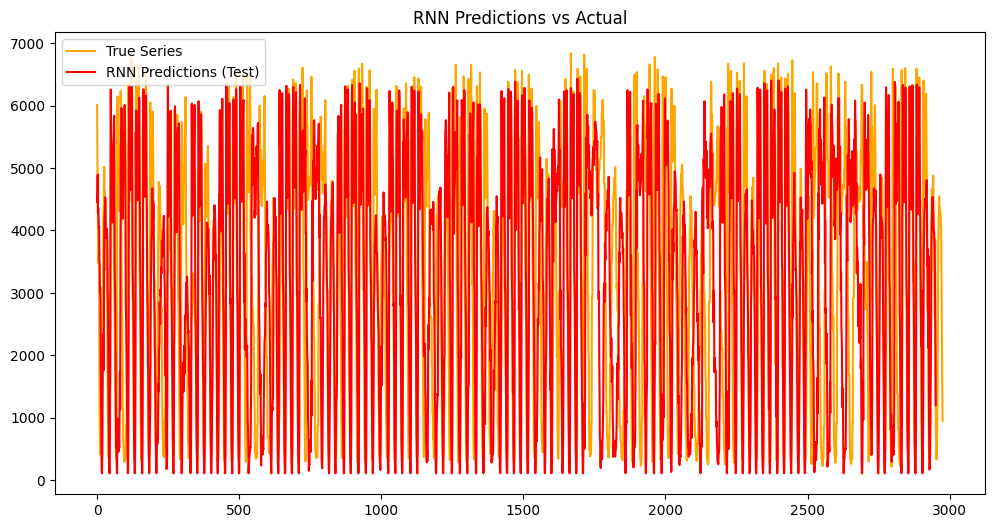

In [48]:
rnn_arr = np.zeros(len(test_data))
rnn_arr[:win_size] = np.nan



#RNN

rnn_arr = rnn_predictions_test[win_size:].flatten()

plt.figure(figsize=(12, 6))
plt.plot(test_plotting_data[win_size:,0], label='True Series',color='orange')
plt.plot(rnn_arr, label='RNN Predictions (Test)', color='red')

plt.legend()
plt.title('RNN Predictions vs Actual')
plt.show()


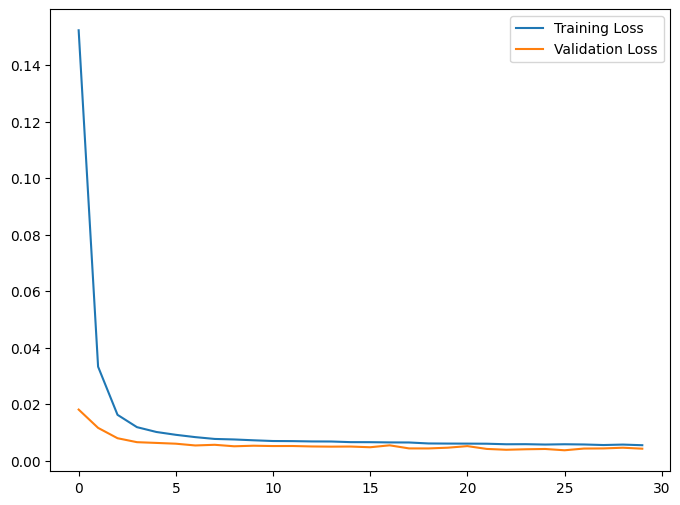

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(RNN_history.history['loss'], label='Training Loss')
plt.plot(RNN_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [65]:
GRU_model = Sequential()

GRU_model.add(GRU(64,return_sequences = True))
GRU_model.add(Dropout(0.2))

GRU_model.add(GRU(128,return_sequences = True))
GRU_model.add(Dropout(0.2))

GRU_model.add(GRU(64))


GRU_model.add(Dense(1,activation='relu'))

GRU_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [66]:
GRU_history = GRU_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0300 - mae: 0.1282 - val_loss: 0.0072 - val_mae: 0.0626
Epoch 2/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0076 - mae: 0.0644 - val_loss: 0.0062 - val_mae: 0.0588
Epoch 3/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0066 - mae: 0.0599 - val_loss: 0.0050 - val_mae: 0.0519
Epoch 4/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0061 - mae: 0.0571 - val_loss: 0.0045 - val_mae: 0.0481
Epoch 5/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0058 - mae: 0.0552 - val_loss: 0.0041 - val_mae: 0.0459
Epoch 6/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0054 - mae: 0.0531 - val_loss: 0.0037 - val_mae: 0.0436
Epoch 7/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0052 - mae: 0.0519 - val_loss: 0.0038 - val_mae: 0.0437
Epoch 8/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0050 - mae: 0.0506 - val_loss: 0.0035 - val_mae: 0.0416
Epoch 9/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [67]:
GRU_predictions = GRU_model.predict(train_ds)
GRU_predictions_test = GRU_model.predict(test_ds)
GRU_predictions_val = GRU_model.predict(val_ds)

GRU_predictions = target_scaler.inverse_transform(GRU_predictions)
GRU_predictions_test = target_scaler.inverse_transform(GRU_predictions_test)
GRU_predictions_val = target_scaler.inverse_transform(GRU_predictions_val)

437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [68]:
print(f'Test MAE: {mean_absolute_error(test_data[win_size:,0], GRU_predictions_test.flatten())}')

Test MAE: 3216.3849572457993


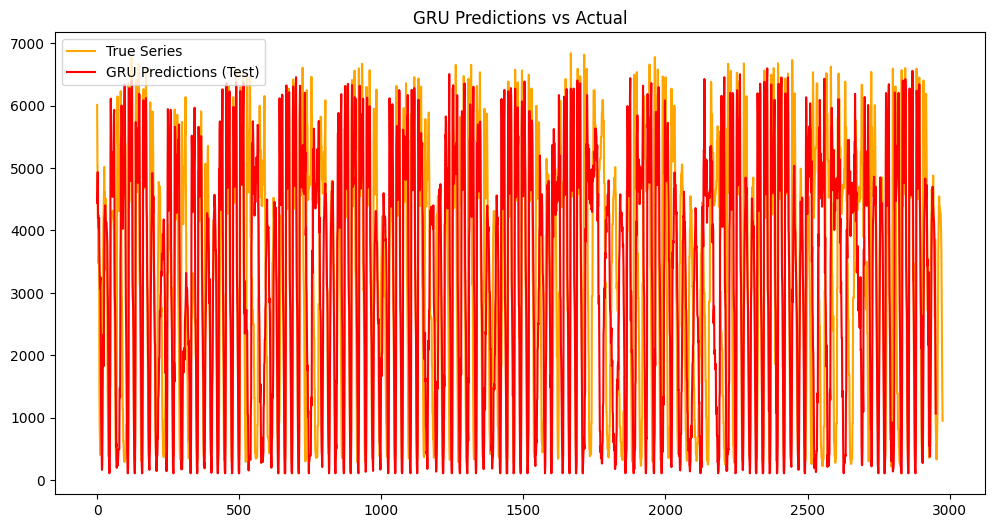

In [69]:
gru_arr = np.zeros(len(test_data))
gru_arr[:win_size] = np.nan

#GRU

gru_arr = GRU_predictions_test[win_size:].flatten()

plt.figure(figsize=(12, 6))
plt.plot(test_plotting_data[win_size:,0], label='True Series',color='orange')
plt.plot(gru_arr, label='GRU Predictions (Test)', color='red')
plt.legend()
plt.title('GRU Predictions vs Actual')
plt.show()


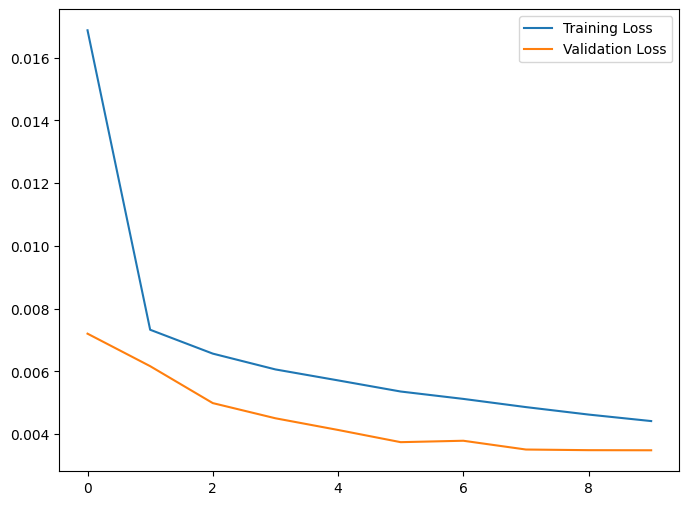

In [70]:
plt.figure(figsize=(8, 6))
plt.plot(GRU_history.history['loss'], label='Training Loss')
plt.plot(GRU_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### **EXTRA STEP (Tuner)**

In [109]:
def build_model(hp):
  tuend_GRU_model = Sequential()

  tuend_GRU_model.add(GRU(units=hp.Int('unit1',min_value=32,max_value=256,step=32),return_sequences=True))
  tuend_GRU_model.add(Dropout(0.2))

  tuend_GRU_model.add(GRU(units=hp.Int('unit2',min_value=32,max_value=256,step=32)))
  tuend_GRU_model.add(Dropout(0.2))

  tuend_GRU_model.add(Dense(1,activation='relu'))

  tuend_GRU_model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),loss='mse',metrics=['mae'])

  return tuend_GRU_model

In [112]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=5,
    directory='tuning',
    project_name='tune'
)

In [113]:
tuner.search(train_ds,epochs=5, validation_data=val_ds)

Trial 5 Complete [00h 00m 34s]
val_mae: 0.04708392173051834

Best val_mae So Far: 0.04708392173051834
Total elapsed time: 00h 03m 03s


In [114]:
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]
best_params.values

{'unit1': 192, 'unit2': 160, 'learning_rate': 0.001}

In [115]:
best_model = tuner.hypermodel.build(best_params)
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [117]:
tEarly_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [118]:
history = best_model.fit(train_ds,epochs=10, validation_data=val_ds,callbacks=tEarly_stopping)

Epoch 1/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0233 - mae: 0.1101 - val_loss: 0.0064 - val_mae: 0.0572
Epoch 2/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0078 - mae: 0.0645 - val_loss: 0.0055 - val_mae: 0.0545
Epoch 3/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0070 - mae: 0.0609 - val_loss: 0.0050 - val_mae: 0.0527
Epoch 4/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0066 - mae: 0.0597 - val_loss: 0.0047 - val_mae: 0.0501
Epoch 5/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0063 - mae: 0.0575 - val_loss: 0.0044 - val_mae: 0.0481
Epoch 6/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0058 - mae: 0.0548 - val_loss: 0.0041 - val_mae: 0.0460
Epoch 7/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0056 - mae: 0.0537 - val_loss: 0.0039 - val_mae: 0.0440
Epoch 8/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0053 - mae: 0.0522 - val_loss: 0.0037 - val_mae: 0.0427
Epoch 9/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms

In [119]:
tuned_GRU_pred = best_model.predict(train_ds)
tuned_GRU_pred_val = best_model.predict(val_ds)
tuned_GRU_pred_test = best_model.predict(test_ds)

tuned_GRU_pred = target_scaler.inverse_transform(tuned_GRU_pred)
tuned_GRU_pred_val = target_scaler.inverse_transform(tuned_GRU_pred_val)
tuned_GRU_pred_test = target_scaler.inverse_transform(tuned_GRU_pred_test)


437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


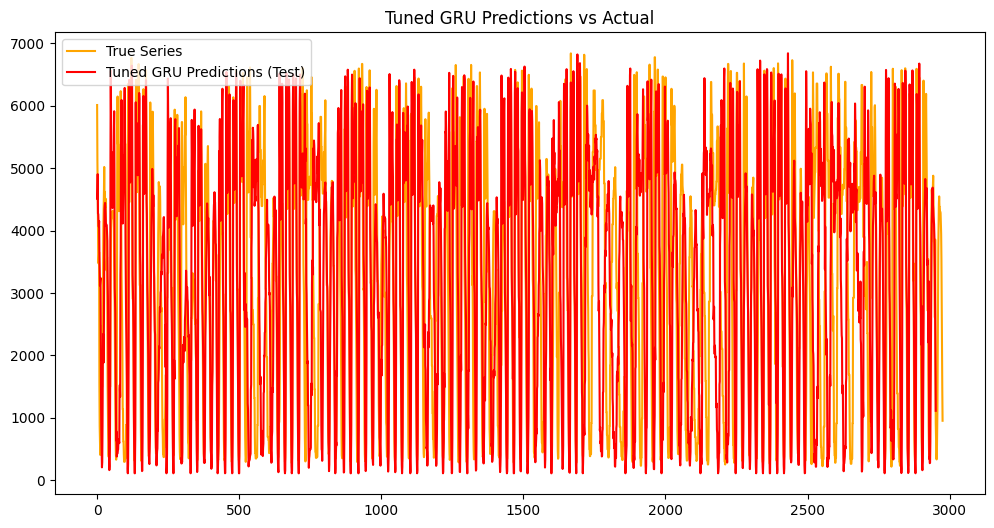

In [121]:
t_gru_arr = np.zeros(len(test_data))
t_gru_arr[:win_size] = np.nan

#Tuned GRU

t_gru_arr = tuned_GRU_pred_test[win_size:].flatten()

plt.figure(figsize=(12, 6))
plt.plot(test_plotting_data[win_size:,0], label='True Series',color='orange')
plt.plot(t_gru_arr, label='Tuned GRU Predictions (Test)', color='red')
plt.legend()
plt.title('Tuned GRU Predictions vs Actual')
plt.show()


In [124]:
print(f'Test MAE: {mean_absolute_error(test_data[win_size:,0], tuned_GRU_pred_test.flatten())}')

Test MAE: 3275.3715887161416


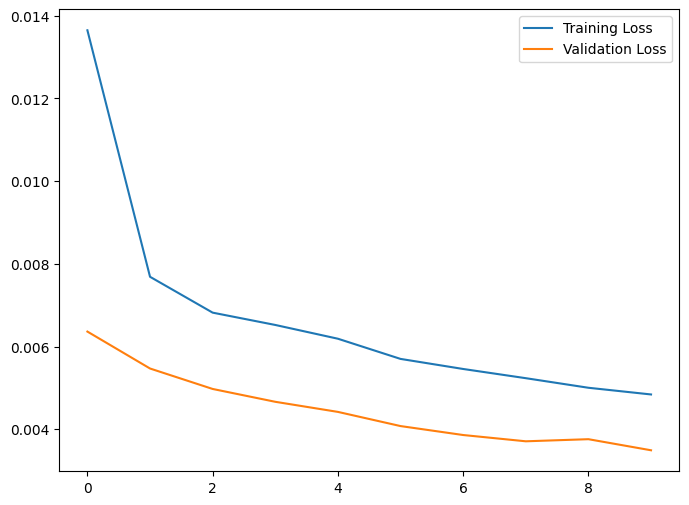

In [123]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

**Data Preprocessing:** started by setting date as index then sorting it to orgnize the data in time series, then missing values where filled using backward fill (bfill), and outliers where handeled using a window that slides on each 90 hours to cach the zscore and set the outliers that are far from the mean (>3)
then been set to null to fill it after that using bfillm, in the next step data where splitten and normlized in carefull way by fitting the scalers on the training data then applying transforming the validation and testing data with tha fitted scaler to avoid data leakage while in the training dataset, these date preprocessing techniques help simplifing the data and clean, prepare it to the modling phase.


**Feature Engineering:** in this step i slected which columns effect the target the most by plotting the correlation matrix, and created a new column called (traffic_moving_avg_24h) that represnts the moving avg of the data to help the model generalize the data better.

**Model Arch:** i choosed SimpleRNN cause its the simplist one and GRU becuase it carries LSTM consept but with less complixit, when building the model we start with a simple arch and that waht i did, the model kept underfitting so i incresed its complixity by adding layers and units while keeping attention to the training, validation loss so its don't overfit, and appling dropout layer and a earlystopping callabck to avoid overfitting

**Training process:** the trainig process went well in the first look, but the MAE is high and there is room for imporvment by processing and engineering the data in better way to and using tuners to get the best model arch

**Model Tuning:** a small fine tunining example was applied on a 2 GRU layers and 5 models with 5 epochs for each just to showcase my understanding not going deep becuase of time limitation and resources, (colab gpu usage exeeded its limit)

**Overfitting & Underfitting:** at the begining the model was underfitting till the arch was improved and there is no overfitting

**Future improvments:** for this part, different algo may be used like LSTM, SARIMA, etc. also decomposed data can be helpfull if it was engaged in the training process as a features to help the model generalize the data better